# Setup

In [1]:
## Install required packages
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116
#!pip install transformers==4.21.2
#!pip install sentencepiece==0.1.96
#!pip install datasets
#!pip install nltk
#!pip install sentence_transformers
#!pip install gensim
#!pip install torchtext
#!pip install pacmap


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.manifold import trustworthiness, TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support, classification_report, f1_score, silhouette_score
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import torch
from transformers import XLMRobertaForSequenceClassification, BertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, DataCollatorForLanguageModeling, RobertaForSequenceClassification, TrainingArguments, Trainer, BertModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from datasets import Dataset, DatasetDict
from utils import functions
import random
import nltk
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
import re
from nltk.corpus import stopwords
from gensim.utils import tokenize as tk
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces
from gensim.models import Doc2Vec
from collections import namedtuple
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD
from pynndescent import NNDescent
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
import pacmap

In [3]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA GeForce RTX 3090'

In [4]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

# Application

### Data preparation

In [5]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8")

In [6]:
manifesto.head()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
0,La France est plus riche que jamais.,2012,503,3,31021_201206,31,31021,France,Front de Gauche,Left Front
1,Mais jamais non plus cette richesse n'a été au...,2012,503,4,31021_201206,31,31021,France,Front de Gauche,Left Front
2,Les réformes libérales qui se sont encore accé...,2012,503,5,31021_201206,31,31021,France,Front de Gauche,Left Front
3,"La pauvreté et la précarité se sont étendues, ...",2012,503,6,31021_201206,31,31021,France,Front de Gauche,Left Front
4,L'égoïsme social des possédants viole l'intérê...,2012,503,7,31021_201206,31,31021,France,Front de Gauche,Left Front


In [7]:
set(manifesto.code)

{'000',
 '101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706',
 'H'}

In [8]:
manifesto = manifesto[(manifesto.code.notna()) & ~(manifesto.code == 'H')].reset_index(drop=True)

In [9]:
set(manifesto.code)

{'000',
 '101',
 '102',
 '103',
 '103.1',
 '103.2',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '201',
 '201.1',
 '201.2',
 '202',
 '202.1',
 '202.2',
 '202.3',
 '202.4',
 '203',
 '204',
 '301',
 '302',
 '303',
 '304',
 '305',
 '305.1',
 '305.2',
 '305.3',
 '305.5',
 '305.6',
 '401',
 '402',
 '403',
 '404',
 '405',
 '406',
 '407',
 '408',
 '409',
 '410',
 '411',
 '412',
 '413',
 '414',
 '415',
 '416',
 '416.1',
 '416.2',
 '501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '507',
 '601',
 '601.1',
 '601.2',
 '602',
 '602.1',
 '602.2',
 '603',
 '604',
 '605',
 '605.1',
 '605.2',
 '606',
 '606.1',
 '606.2',
 '607',
 '607.1',
 '607.2',
 '607.3',
 '608',
 '608.1',
 '608.2',
 '701',
 '702',
 '703',
 '703.1',
 '703.2',
 '704',
 '705',
 '706'}

In [10]:
from utils.functions import extract_code
manifesto['code_extract'] = manifesto['code'].apply(extract_code)

In [11]:
len(set(manifesto.code_extract))

57

In [12]:
manifesto.groupby('code_extract').count()

,text,election,code,pos,party_code,country_code,party,country,name,name_english
code_extract,,,,,,,,,,
0,1905,1905,1905,1905,1905,1905,1905,1905,1905,1905
101,907,907,907,907,907,907,907,907,907,907
102,97,97,97,97,97,97,97,97,97,97
103,406,406,406,406,406,406,406,406,406,406
104,3433,3433,3433,3433,3433,3433,3433,3433,3433,3433
105,2280,2280,2280,2280,2280,2280,2280,2280,2280,2280
106,1545,1545,1545,1545,1545,1545,1545,1545,1545,1545
107,7520,7520,7520,7520,7520,7520,7520,7520,7520,7520
108,5088,5088,5088,5088,5088,5088,5088,5088,5088,5088


In [13]:
texts = manifesto['text'].tolist()

In [14]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 20.4236371346128
Std length (word) is: 12.819031850456408
Min length (word) is: 1
Max length (word) is: 160


<AxesSubplot: >

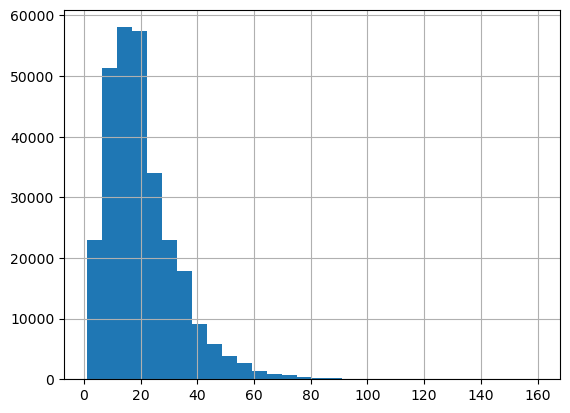

In [15]:
pd.Series(seq_len).hist(bins = 30)

In [16]:
### Group texts to decrease the number of sentences
manifesto['country_party_election_code'] = manifesto.country.str.cat(others=[manifesto.name, manifesto.election.astype(str), 
manifesto.code_extract.astype(str)], sep='_')


In [17]:
from utils.functions import group_texts
results = group_texts(manifesto, 'country_party_election_code','text', group_factor = 4)

Length of Italy_Lista di Pietro - Italia del Valori_2008_505 is: 3
Length of France_Front National_2017_402 is: 4
Length of United Kingdom_Conservative Party_2015_408 is: 1
Length of Germany_Freie Demokratische Partei_2017_505 is: 26
Length of Germany_Freie Demokratische Partei_2017_604 is: 13
Length of Germany_Freie Demokratische Partei_2002_704 is: 4
Length of Italy_Lista di Pietro - Italia del Valori_2001_601 is: 1
Length of Italy_Südtiroler Volkspartei_2013_411 is: 26
Length of Spain_Coalición Canaria - Nueva Canarias_2015_303 is: 8
Length of France_Alliance Centriste_2012_303 is: 2
Length of Spain_Podemos_2016_405 is: 5
Length of Germany_Bündnis‘90/Die Grünen_2009_203 is: 4
Length of United Kingdom_Scottish National Party_2015_402 is: 54
Length of Spain_Unidad Popular_2015_705 is: 7
Length of United Kingdom_Green Party of England and Wales_2019_602 is: 5
Length of United Kingdom_Plaid Cymru_2017_411 is: 31
Length of France_Europe Écologie Les Verts_2012_703 is: 49
Length of Spain_

In [18]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [19]:
df_cols = manifesto_regrouped['labels'].str.split('_', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)

In [20]:
manifesto_regrouped.columns = ['text', 'country_party_election_code', 'country','party', 'election', 'code']

In [21]:
manifesto_regrouped.groupby('code').count()

,text,country_party_election_code,country,party,election
code,,,,,
0,524,524,524,524,524
101,260,260,260,260,260
102,36,36,36,36,36
103,134,134,134,134,134
104,907,907,907,907,907
105,631,631,631,631,631
106,452,452,452,452,452
107,1961,1961,1961,1961,1961
108,1342,1342,1342,1342,1342


In [22]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 78.24219131766975
Std length (word) is: 36.01295814143997
Min length (word) is: 1
Max length (word) is: 353


<AxesSubplot: >

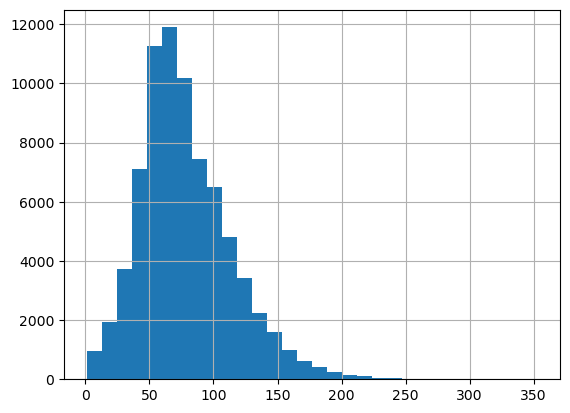

In [23]:
pd.Series(seq_len).hist(bins = 30)

### Domain adaptation with TSDAE

In [25]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader

In [26]:
model_name = 'xlm-roberta-base'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
train_sentences = manifesto_regrouped['text'].tolist()
train_dataset = datasets.DenoisingAutoEncoderDataset(train_sentences)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=model_name, tie_encoder_decoder=True)

When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Some weights of XLMRobertaForCausalLM were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.encoder.layer.8.crossattention.self.query.bias', 'roberta.encoder.layer.5.crossattention.self.key.bias', 'roberta.encoder.layer.11.crossattention.self.key.bias', 'roberta.encoder.layer.11.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.6.crossattention.self.key.weight', 'roberta.encoder.layer.4.crossattention.self.query.weight', 'roberta.encoder.layer.9.crossattention.self.query.weight', 'roberta.encoder.layer.11.crossattention.self.query.weight', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.10.crossattention.self.value.weight', 'roberta.encoder.layer.5.crossattention.self.query.bias', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encod

In [27]:
len(train_sentences)

75717

In [28]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/9465 [00:00<?, ?it/s]

Iteration:   0%|          | 0/9465 [00:00<?, ?it/s]

In [ ]:
model.save('results/tsdae-model')

### Domain adaptation through fine-tuning: left - right - neutral

In [104]:
from utils.functions import lr_code 

In [105]:
manifesto_regrouped['lrn'] = manifesto_regrouped['code'].astype(int).apply(lr_code)

In [106]:
manifesto_regrouped.groupby('lrn').count()

,text,country_party_election_code,country,party,election,code
lrn,,,,,,
left,30032,30032,30032,30032,30032,30032
neutral,31186,31186,31186,31186,31186,31186
right,14499,14499,14499,14499,14499,14499


In [107]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading file senten

In [108]:
manifesto_reduced = manifesto_regrouped[['lrn','text']]

In [109]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('lrn')
manifesto_dataset = manifesto_dataset.rename_column('lrn','labels')



Casting to class labels:   0%|          | 0/76 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/8 [00:00<?, ?ba/s]

In [110]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [111]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 47701
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 7572
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 20444
    })
})

In [112]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [113]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

In [114]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [115]:
num_classes = len(set(manifesto_regrouped['lrn']))
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002


In [116]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [117]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_3cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [118]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [119]:
trainer.train()

***** Running training *****
  Num examples = 47701
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4473
  Number of trainable parameters = 278045955


  0%|          | 0/4473 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.8142, 'learning_rate': 1.8019226469930697e-05, 'epoch': 0.3}
{'loss': 0.5963, 'learning_rate': 1.602056785155377e-05, 'epoch': 0.6}
{'loss': 0.558, 'learning_rate': 1.402190923317684e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8410596026490066, 0.8474205583429821, 0.6730934018851756]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8300653594771242, 0.7823040380047506, 0.8025542784163474]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8355263157894738, 0.8135614154264188, 0.7321449376674822]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8300653594771242, 0.7823040380047506, 0.8025542784163474]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect s

{'eval_loss': 0.5049565434455872, 'eval_precision': [0.8410596026490066, 0.8474205583429821, 0.6730934018851756], 'eval_recall': [0.8300653594771242, 0.7823040380047506, 0.8025542784163474], 'eval_f1': [0.8355263157894738, 0.8135614154264188, 0.7321449376674822], 'eval_accuracy': [0.8300653594771242, 0.7823040380047506, 0.8025542784163474], 'eval_runtime': 46.3272, 'eval_samples_per_second': 441.296, 'eval_steps_per_second': 13.793, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-1491\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-1491\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-1491\special_tokens_map.json


{'loss': 0.466, 'learning_rate': 1.2032193158953724e-05, 'epoch': 1.2}
{'loss': 0.4284, 'learning_rate': 1.0033534540576794e-05, 'epoch': 1.5}
{'loss': 0.4092, 'learning_rate': 8.034875922199866e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8230279609002046, 0.8705577172503243, 0.7660060975609756]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8929584412381305, 0.7971496437054632, 0.7701149425287356]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8565682853256048, 0.832238065716057, 0.7680550248376004]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8929584412381305, 0.7971496437054632, 0.7701149425287356]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.4584812819957733, 'eval_precision': [0.8230279609002046, 0.8705577172503243, 0.7660060975609756], 'eval_recall': [0.8929584412381305, 0.7971496437054632, 0.7701149425287356], 'eval_f1': [0.8565682853256048, 0.832238065716057, 0.7680550248376004], 'eval_accuracy': [0.8929584412381305, 0.7971496437054632, 0.7701149425287356], 'eval_runtime': 44.3034, 'eval_samples_per_second': 461.454, 'eval_steps_per_second': 14.423, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-2982\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-2982\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-2982\special_tokens_map.json


{'loss': 0.3855, 'learning_rate': 6.036217303822938e-06, 'epoch': 2.1}
{'loss': 0.3218, 'learning_rate': 4.0375586854460095e-06, 'epoch': 2.4}
{'loss': 0.317, 'learning_rate': 2.0389000670690815e-06, 'epoch': 2.7}
{'loss': 0.306, 'learning_rate': 4.0241448692152927e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8626482213438735, 0.8445132848802573, 0.7734513274336283]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612652608213096, 0.8418052256532067, 0.7813537675606641]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8619561863622338, 0.84315708083031, 0.7773824650571792]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612652608213096, 0.8418052256532067, 0.7813537675606641]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so 

{'eval_loss': 0.45922592282295227, 'eval_precision': [0.8626482213438735, 0.8445132848802573, 0.7734513274336283], 'eval_recall': [0.8612652608213096, 0.8418052256532067, 0.7813537675606641], 'eval_f1': [0.8619561863622338, 0.84315708083031, 0.7773824650571792], 'eval_accuracy': [0.8612652608213096, 0.8418052256532067, 0.7813537675606641], 'eval_runtime': 42.7899, 'eval_samples_per_second': 477.776, 'eval_steps_per_second': 14.933, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_3cl\checkpoint-4473\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl\checkpoint-4473\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl\checkpoint-4473\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_3cl\checkpoint-2982 (score: 0.4584812819957733).


{'train_runtime': 2121.3208, 'train_samples_per_second': 67.459, 'train_steps_per_second': 2.109, 'train_loss': 0.4601726013889735, 'epoch': 3.0}


TrainOutput(global_step=4473, training_loss=0.4601726013889735, metrics={'train_runtime': 2121.3208, 'train_samples_per_second': 67.459, 'train_steps_per_second': 2.109, 'train_loss': 0.4601726013889735, 'epoch': 3.0})

In [120]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 7572
  Batch size = 32


  0%|          | 0/237 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8160219311605239, 0.865797816132441, 0.7558620689655172]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8921078921078921, 0.7880731003526772, 0.7558620689655172]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8523703468024181, 0.8251090970124203, 0.7558620689655172]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8921078921078921, 0.7880731003526772, 0.7558620689655172]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

0.8111138375934518


In [123]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.85,0.82,0.89,0.89
1,0.83,0.87,0.79,0.79
2,0.76,0.76,0.76,0.76


In [124]:
round(res_table.mean(axis=0),2)

f1           0.81
precision    0.82
recall       0.81
accuracy     0.81
dtype: float64

In [125]:
res_table.to_csv('results/tabs and figs/tsdae_ft_cls.csv', index=False)

### Domain adaptation through fine-tuning: sentiment

In [60]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [52]:
manifesto_regrouped['sentiment'] = manifesto_regrouped['code'].astype(int).apply(sentiment_code)
manifesto_regrouped['topic'] = manifesto_regrouped['code'].astype(int).apply(topic_code)



In [53]:
manifesto_reduced = manifesto_regrouped[['sentiment','text']]

In [55]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Parameter 'function'=<function Dataset.class_encode_column.<locals>.cast_to_class_labels at 0x00000221644EA1F0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Casting to class labels:   0%|          | 0/76 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/8 [00:00<?, ?ba/s]

In [56]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [57]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 47701
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 7572
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 20444
    })
})

In [58]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [61]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/48 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

In [62]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [63]:
num_classes = len(set(manifesto_regrouped['sentiment']))
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [64]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [66]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_3cl_sentiment",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [67]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [68]:
trainer.train()

***** Running training *****
  Num examples = 47701
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4473
  Number of trainable parameters = 278045955


  0%|          | 0/4473 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.8049, 'learning_rate': 1.8010283925776887e-05, 'epoch': 0.3}
{'loss': 0.6135, 'learning_rate': 1.602056785155377e-05, 'epoch': 0.6}
{'loss': 0.5634, 'learning_rate': 1.4035323049407556e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.629863301787592, 0.7914996836110525, 0.8829695400172648]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6692737430167598, 0.8609613399105197, 0.7918602079186021]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6489707475622968, 0.8247705917907577, 0.8349367383826016]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6692737430167598, 0.8609613399105197, 0.7918602079186021]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.4952334463596344, 'eval_precision': [0.629863301787592, 0.7914996836110525, 0.8829695400172648], 'eval_recall': [0.6692737430167598, 0.8609613399105197, 0.7918602079186021], 'eval_f1': [0.6489707475622968, 0.8247705917907577, 0.8349367383826016], 'eval_accuracy': [0.6692737430167598, 0.8609613399105197, 0.7918602079186021], 'eval_runtime': 37.4651, 'eval_samples_per_second': 545.682, 'eval_steps_per_second': 17.056, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-1491\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-1491\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-1491\special_tokens_map.json


{'loss': 0.4745, 'learning_rate': 1.203666443103063e-05, 'epoch': 1.2}
{'loss': 0.4389, 'learning_rate': 1.00380058126537e-05, 'epoch': 1.5}
{'loss': 0.4339, 'learning_rate': 8.039347194276772e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.6829710144927537, 0.8467599670704458, 0.8513233852521512]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.702048417132216, 0.8259722381553287, 0.8644105286441053]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.692378328741965, 0.8362369337979095, 0.8578170443944465]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.702048417132216, 0.8259722381553287, 0.8644105286441053]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so w

{'eval_loss': 0.4489334225654602, 'eval_precision': [0.6829710144927537, 0.8467599670704458, 0.8513233852521512], 'eval_recall': [0.702048417132216, 0.8259722381553287, 0.8644105286441053], 'eval_f1': [0.692378328741965, 0.8362369337979095, 0.8578170443944465], 'eval_accuracy': [0.702048417132216, 0.8259722381553287, 0.8644105286441053], 'eval_runtime': 39.538, 'eval_samples_per_second': 517.073, 'eval_steps_per_second': 16.162, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-2982\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-2982\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-2982\special_tokens_map.json


{'loss': 0.3924, 'learning_rate': 6.040688575899843e-06, 'epoch': 2.1}
{'loss': 0.3342, 'learning_rate': 4.0420299575229155e-06, 'epoch': 2.4}
{'loss': 0.3269, 'learning_rate': 2.043371339145987e-06, 'epoch': 2.7}
{'loss': 0.3216, 'learning_rate': 4.4712720769058795e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 20444
  Batch size = 32


  0%|          | 0/639 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7338969404186796, 0.8377805068661383, 0.866377874041986]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6789571694599628, 0.8608466215441092, 0.8626410086264101]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7053588701876572, 0.8491569537173249, 0.8645054031587698]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.6789571694599628, 0.8608466215441092, 0.8626410086264101]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

{'eval_loss': 0.4674117863178253, 'eval_precision': [0.7338969404186796, 0.8377805068661383, 0.866377874041986], 'eval_recall': [0.6789571694599628, 0.8608466215441092, 0.8626410086264101], 'eval_f1': [0.7053588701876572, 0.8491569537173249, 0.8645054031587698], 'eval_accuracy': [0.6789571694599628, 0.8608466215441092, 0.8626410086264101], 'eval_runtime': 38.3859, 'eval_samples_per_second': 532.591, 'eval_steps_per_second': 16.647, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-4473\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-4473\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_3cl_sentiment\checkpoint-4473\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_3cl_sentiment\checkpoint-2982 (score: 0.4489334225654602).


{'train_runtime': 1176.4768, 'train_samples_per_second': 121.637, 'train_steps_per_second': 3.802, 'train_loss': 0.47034727338440807, 'epoch': 3.0}


TrainOutput(global_step=4473, training_loss=0.47034727338440807, metrics={'train_runtime': 1176.4768, 'train_samples_per_second': 121.637, 'train_steps_per_second': 3.802, 'train_loss': 0.47034727338440807, 'epoch': 3.0})

In [69]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 7572
  Batch size = 32


  0%|          | 0/237 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.6972386587771203, 0.8565022421524664, 0.8483701979045402]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7112676056338029, 0.8281201610405698, 0.8704090773365184]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.704183266932271, 0.8420721146276176, 0.8592483419307296]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7112676056338029, 0.8281201610405698, 0.8704090773365184]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so

0.8018345744968727


In [72]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.70,0.70,0.71,0.71
1,0.84,0.86,0.83,0.83
2,0.86,0.85,0.87,0.87


In [73]:
round(res_table.mean(axis=0),2)

f1           0.8
precision    0.8
recall       0.8
accuracy     0.8
dtype: float64

In [74]:
res_table.to_csv('results/tabs and figs/ft_sentiment.csv', index=False)

### Example 1: Germany - CMP code

#### Sentence Transformer to extract sentence embeddings

In [24]:
from utils.functions import party_deu, cmp_scale, lr_code

In [25]:
manifesto_deu = manifesto[manifesto['country'] == 'Germany'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_regrouped[manifesto_regrouped['country'] == 'Germany'].reset_index(drop=True)

In [26]:
manifesto_deu['party_agg'] = manifesto_deu['name'].apply(party_deu)
manifesto_deu_rgr['party_agg'] = manifesto_deu_rgr['party'].apply(party_deu)


In [27]:
manifesto_deu_rgr['lrn'] = manifesto_deu_rgr['code'].astype(int).apply(lr_code)
manifesto_deu['lrn'] = manifesto_deu['code_extract'].astype(int).apply(lr_code)

In [28]:
manifesto_deu = manifesto_deu[manifesto_deu.party_agg != 'NA'].reset_index(drop=True)
manifesto_deu_rgr = manifesto_deu_rgr[manifesto_deu_rgr.party_agg != 'NA'].reset_index(drop=True)

In [32]:
manifesto_deu_rgr.head()

,text,country_party_election_code,country,party,election,code,party_agg,lrn
0,Nehmen wir die Gestaltung des digitalen Wandel...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,411,SPD,neutral
1,und der mangelnden Infrastruktur im ländlichen...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,411,SPD,neutral
2,für die Digitalisierung Wir werden diese vier ...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,411,SPD,neutral
3,und je schneller die nötigen Stromleitungen un...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,411,SPD,neutral
4,Der Ausbau dieser Infrastrukturen muss dem Bed...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,411,SPD,neutral


In [33]:
manifesto_deu_rgr.groupby('lrn').count()

,text,country_party_election_code,country,party,election,code,party_agg
lrn,,,,,,,
left,8104,8104,8104,8104,8104,8104,8104
neutral,7756,7756,7756,7756,7756,7756,7756
right,4533,4533,4533,4533,4533,4533,4533


In [29]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='lrn')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


#### Scaling with Supervised UMAP

In [30]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [31]:
from utils.functions import scale_topic

In [73]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256, guidance_weight=0.75, use_pca=False,n_components=2, random_state=seed_val, metric='cosine')

The shape of this document embeddings is: (20393, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=500, random_state=1234, target_weight=0.75, verbose=True)
Thu Sep 28 23:26:40 2023 Construct fuzzy simplicial set
Thu Sep 28 23:26:40 2023 Finding Nearest Neighbors
Thu Sep 28 23:26:40 2023 Building RP forest with 12 trees
Thu Sep 28 23:26:40 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 23:27:06 2023 Finished Nearest Neighbor Search
Thu Sep 28 23:27:10 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 23:27:39 2023 Finished embedding


In [155]:
umap_s_scaled = scaled_results[1]

In [163]:
np.std(umap_s_scaled[:,0])

10.155877

In [218]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = umap_s_scaled[idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [219]:
umap_s_pos = np.stack(list(emb_mean_dict.values()))


In [220]:
umap_s_se = np.stack(list(emb_se_dict.values()))


In [196]:
np.corrcoef(logscale,umap_s_pos[:,0])

array([[ 1.        , -0.99165357],
       [-0.99165357,  1.        ]])

In [80]:
## Silhouette score
umap_s_silscore = silhouette_score(umap_s_scaled, scaled_results[2].flatten())
umap_s_silscore

0.81033605

In [93]:
## Trustworthiness
umap_s_trust = trustworthiness(scaled_results[3], umap_s_scaled, n_neighbors=5)
umap_s_trust

0.9785030493698025

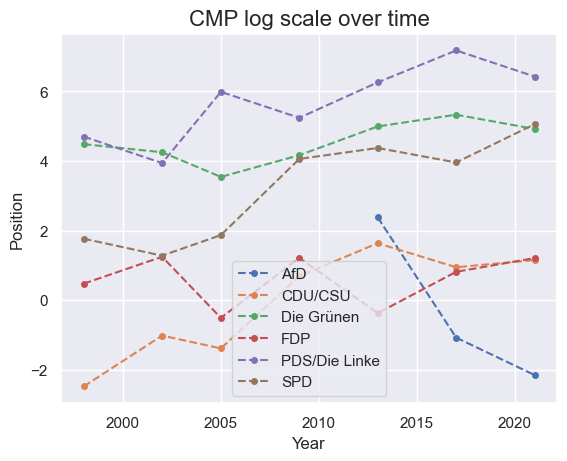

In [221]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_rgr.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'umap_dim1': umap_s_pos[:,0], 'umap_dim2': umap_s_pos[:,1], 'se_dim1': umap_s_se[:,0], 'se_dim2': umap_s_se[:,1],'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) 
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.umap_dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()
plt.savefig('results/tabs and figs/figure5.png', dpi=300)

In [222]:
df.to_csv("results/arrays/df_main.csv", index=False)

In [72]:
## Save data
np.savetxt('results/arrays/umap_s_scaled.csv', umap_s_scaled)
np.savetxt('results/arrays/umap_s_embeds.csv', umap_s_pos)


### Example 2: Germany - by topic 

In [63]:
from utils.functions import sentiment_code, topic_code

In [64]:
manifesto_deu_rgr['sentiment'] = manifesto_deu_rgr['code'].astype(int).apply(sentiment_code)
manifesto_deu_rgr['topic'] = manifesto_deu_rgr['code'].astype(int).apply(topic_code)

manifesto_deu['sentiment'] = manifesto_deu['code_extract'].astype(int).apply(sentiment_code)
manifesto_deu['topic'] = manifesto_deu['code_extract'].astype(int).apply(topic_code)

In [65]:
manifesto_deu_rgr.groupby(['topic','sentiment']).count()

text  country_party_election_code  country  \
topic                   sentiment                                               
constitutionalism       negative     13                           13       13   
                        positive     51                           51       51   
decentralisation        negative     77                           77       77   
                        positive    310                          310      310   
education               negative     14                           14       14   
                        positive    759                          759      759   
environment             negative    178                          178      178   
                        positive   1618                         1618     1618   
eu                      negative    123                          123      123   
                        positive    500                          500      500   
freemarket              negative   1412                         1412     1412   
                        positive    775                          775      775   
international relations negative     49                           49       49   
                        positive    752                          752      752   
irrelevant              unknown    9382                         9382     9382   
keynesian               negative    248                          248      248   
                        positive     66                           66       66   
labour groups           negative     37                           37       37   
                        positive   1012                         1012     1012   
military                negative    259                          259      259   
                        positive    189                          189      189   
multiculturalism        negative     92                           92       92   
                        positive    246                          246      246   
protectionism           negative     54                           54       54   
                        positive     35                           35       35   
traditionalism          negative    303                          303      303   
                        positive    488                          488      488   
welfare                 negative    119                          119      119   
                        positive   1232                         1232     1232   

                                   party  election  code  party_agg   lrn  \
topic                   sentiment                                           
constitutionalism       negative      13        13    13         13    13   
                        positive      51        51    51         51    51   
decentralisation        negative      77        77    77         77    77   
                        positive     310       310   310        310   310   
education               negative      14        14    14         14    14   
                        positive     759       759   759        759   759   
environment             negative     178       178   178        178   178   
                        positive    1618      1618  1618       1618  1618   
eu                      negative     123       123   123        123   123   
                        positive     500       500   500        500   500   
freemarket              negative    1412      1412  1412       1412  1412   
                        positive     775       775   775        775   775   
international relations negative      49        49    49         49    49   
                        positive     752       752   752        752   752   
irrelevant              unknown     9382      9382  9382       9382  9382   
keynesian               negative     248       248   248        248   248   
                        positive      66        66    66         66    66   
labour groups           negative      37        37    37    

In [66]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl_sentiment/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl_sentiment/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a d

#### Traditionalism

In [68]:
manifesto_deu_rgr_td = manifesto_deu_rgr[manifesto_deu_rgr.topic == 'traditionalism'].reset_index(drop=True)
manifesto_deu_td = manifesto_deu[manifesto_deu.topic == 'traditionalism'].reset_index(drop=True)

In [69]:
len(manifesto_deu_rgr_td)

791

In [82]:
manifesto_deu_rgr_td.groupby('sentiment').count()

,text,country_party_election_code,country,party,election,code,party_agg,lrn,text_cleaned,party_election,topic
sentiment,,,,,,,,,,,
negative,303,303,303,303,303,303,303,303,303,303,303
positive,488,488,488,488,488,488,488,488,488,488,488


In [83]:
def cmp_scale_sentiment(dataframe, group_vars, sent_var):
    relscale = []
    absscale = []
    logscale = []
    name_ls = []
    for name, group in dataframe.groupby(group_vars):
        print(name)
        text = group["text"].tolist()
        left = group[group[sent_var] == "negative"][sent_var].tolist()
        right = group[group[sent_var] == "positive"][sent_var].tolist()
        len_all = len(text)
        relscale.append((len(right) - len(left)) / (len(left) + len(right)))
        absscale.append((len(right) - len(left)) / len_all)
        logscale.append(np.log(len(right) + 0.5) - np.log(len(left) + 0.5))
        name_ls.append(name)
    return (absscale, relscale, logscale, name_ls)

In [84]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(manifesto_deu_td, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [114]:
scaled_results = scale_topic(manifesto_deu_rgr_td, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.75, n_components=2, use_pca=False, random_state=4321, metric = 'cosine')

The shape of this document embeddings is: (791, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=4321, target_weight=0.75, verbose=True)
Fri Sep 29 17:01:35 2023 Construct fuzzy simplicial set
Fri Sep 29 17:01:35 2023 Finding Nearest Neighbors
Fri Sep 29 17:01:35 2023 Finished Nearest Neighbor Search
Fri Sep 29 17:01:35 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 17:01:37 2023 Finished embedding


In [115]:
umap_td_scaled = scaled_results[1]

In [116]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = umap_td_scaled[idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [117]:
umap_td_pos = np.stack(list(emb_mean_dict.values()))


In [118]:
umap_td_se = np.stack(list(emb_se_dict.values()))


In [120]:
np.corrcoef(logscale,umap_td_pos[:,1])

array([[ 1.        , -0.95467715],
       [-0.95467715,  1.        ]])

[]

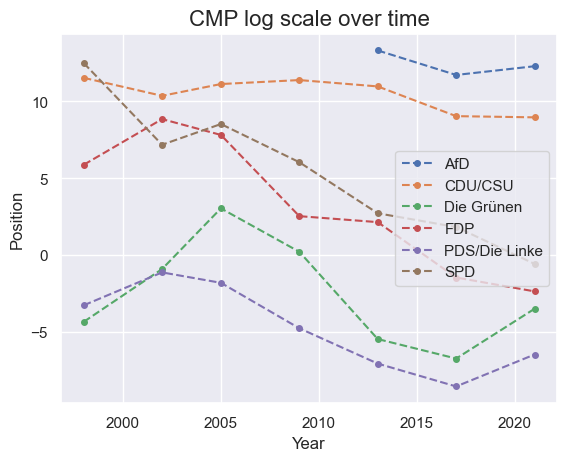

In [121]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_td.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_td_pos[:,0], 'dim2': umap_td_pos[:,1], 'se_dim1': umap_td_se[:,0], 'se_dim2': umap_td_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()


In [123]:
df.to_csv("results/arrays/df_td.csv", index=False)

#### Welfare redistribution

In [124]:
manifesto_deu_rgr_wf = manifesto_deu_rgr[manifesto_deu_rgr.topic == 'welfare'].reset_index(drop=True)
manifesto_deu_wf = manifesto_deu[manifesto_deu.topic == 'welfare'].reset_index(drop=True)

In [125]:
len(manifesto_deu_rgr_wf)

1351

In [126]:
manifesto_deu_rgr_wf.groupby('sentiment').count()

,text,country_party_election_code,country,party,election,code,party_agg,lrn,text_cleaned,party_election,topic
sentiment,,,,,,,,,,,
negative,119,119,119,119,119,119,119,119,119,119,119
positive,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232,1232


In [128]:
absscale, relscale, logscale, name_ls = cmp_scale_sentiment(manifesto_deu_wf, group_vars=['party_agg','election'], sent_var='sentiment')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [129]:
scaled_results = scale_topic(manifesto_deu_rgr_wf, model, 'text', ['party_agg','election'] ,'sentiment', batch_size=256, guidance_weight=0.75, n_components=2, use_pca=False, random_state=4321, metric = 'cosine')

The shape of this document embeddings is: (1351, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=250, random_state=4321, target_weight=0.75, verbose=True)
Fri Sep 29 17:04:39 2023 Construct fuzzy simplicial set
Fri Sep 29 17:04:40 2023 Finding Nearest Neighbors
Fri Sep 29 17:04:40 2023 Finished Nearest Neighbor Search
Fri Sep 29 17:04:40 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Sep 29 17:04:43 2023 Finished embedding


In [130]:
umap_td_scaled = scaled_results[1]

In [131]:
emb_mean_dict = {}
emb_se_dict = {}

for name, group in scaled_results[0].groupby(['party_agg','election']):
    idx = group.index
    embed = umap_td_scaled[idx]
    embed_mean = embed.mean(axis=0)
    embed_se = embed.std(axis=0)/np.sqrt(len(group))
    name_full = '_'.join(name)
    emb_mean_dict.update({name_full: embed_mean})
    emb_se_dict.update({'_'.join([name_full, 'sd']): embed_se})


In [132]:
umap_td_pos = np.stack(list(emb_mean_dict.values()))


In [133]:
umap_td_se = np.stack(list(emb_se_dict.values()))


In [135]:
np.corrcoef(logscale,umap_td_pos[:,0])

array([[ 1.        , -0.84275846],
       [-0.84275846,  1.        ]])

[]

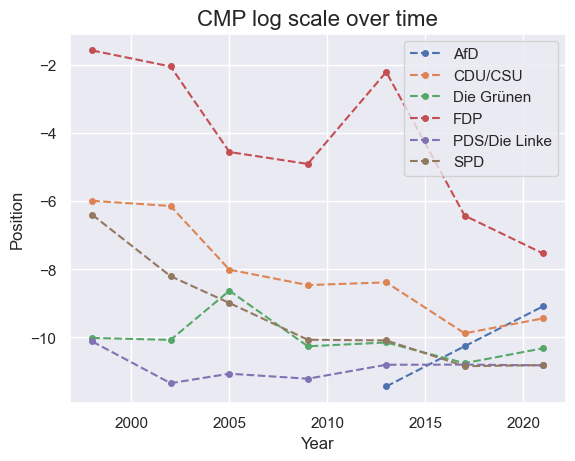

In [136]:
labels = ['_'.join([str(n) for n in name]) for name, group in manifesto_deu_td.groupby(['party_agg','election'])]
party = [lab.split('_')[0] for lab in labels]
year = [int(lab.split('_')[1]) for lab in labels]
#sentiment = [lab.split('_')[2] for lab in labels]


df = pd.DataFrame({'dim1': umap_td_pos[:,0], 'dim2': umap_td_pos[:,1], 'se_dim1': umap_td_se[:,0], 'se_dim2': umap_td_se[:,1], 'party': party, 'election': year, 'lr_prop': relscale, 'lr_log': logscale, 'lr_abs': absscale}) #,'dim2': score[:,1]
import matplotlib.pyplot as plt
sns.set_theme()
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in df.groupby('party'):
    ax.plot(group.election, group.dim1, marker='o', linestyle='dashed', ms=4, label=name)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Position')
ax.set_title('CMP log scale over time', fontdict={'fontsize':16})
plt.plot()


In [137]:
df.to_csv("results/arrays/df_wf.csv", index=False)

# Validity checks

## Validation: Comparing embeddings quality through classification performances

#### Bags-of-words with TF-IDF

In [30]:
## Preprocessing for bag-of-words and word2vec models is a little different (pre-trained)
## Tokenizer - use gensim's tokenizer 
def clean_text(text, stopwords):
    custom_filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces]
    text = preprocess_string(text, custom_filters)
    tokens = [w for w in text if w not in stopwords]
    return ' '.join(tokens)


In [80]:
set(manifesto_regrouped['country'])

{'France', 'Germany', 'Italy', 'Spain', 'United Kingdom'}

In [ ]:
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx}th sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

In [82]:
manifesto_regrouped['text_cleaned'] = outputs

In [83]:
## Before
manifesto_regrouped.loc[0,'text']

"The problem: This country's education has been underfunded and undermined by repeated shifts in policy. Standards are too low, especially in core skills such as reading and maths. Britain is too low in the world league tables."

In [84]:
## After
outputs[0]

'problem country education underfunded undermined repeated shifts policy standards low especially core skills reading maths britain low world league tables'

In [86]:
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.15, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)
df_train, df_eval = train_test_split(df_train, test_size=0.3, stratify = df_train['sentiment'], random_state=seed_val)
enc = OrdinalEncoder()

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))
df_eval['labels'] = enc.fit_transform(np.array(df_eval['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_eval = df_eval.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [87]:
y_train = np.array(df_train['labels'])
y_eval = np.array(df_eval['labels'])
y_test = np.array(df_test['labels'])

In [88]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [95]:
corp_train = df_train['text_cleaned'].tolist()
vectorizer.fit(corp_train)
X_train = vectorizer.transform(corp_train)
dic_vocabulary = vectorizer.vocabulary_

In [96]:
classifier = naive_bayes.MultinomialNB()

In [97]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = df_test["text_cleaned"].tolist()
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [98]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [99]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.71,0.69,0.73,0.73
1,0.67,0.67,0.68,0.68
2,0.50,0.56,0.45,0.45


In [100]:
round(res_table.mean(axis=0),2)

f1           0.63
precision    0.64
recall       0.62
accuracy     0.62
dtype: float64

In [105]:
## Save vectorizer and model to other variables
vect_bow = vectorizer
model_bow = model


#### Doc2Vec


In [57]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1th sentence
Cleaning the 10001th sentence
Cleaning the 20001th sentence
Cleaning the 30001th sentence
Cleaning the 40001th sentence
Cleaning the 50001th sentence
Cleaning the 60001th sentence
Cleaning the 70001th sentence
Cleaning the 80001th sentence
Cleaning the 90001th sentence


In [58]:
manifesto_regrouped['text_cleaned'] = outputs

In [59]:
manifesto_regrouped.head()

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned
0,La lotta per l’eliminazione della mafia e dell...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,lotta l’eliminazione mafia corruzione solo obi...
1,Il debito pubblico italiano deve essere affron...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,debito pubblico italiano deve essere affrontat...
2,Vanno utilizzate le risorse derivanti dalla lo...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,vanno utilizzate risorse derivanti lotta all’e...
3,Affligge il nord come il sud d'Italia. Secondo...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,affligge nord sud d italia secondo l’ultimo da...
4,L’economia che sfugge alle statistiche ufficia...,Italy_Rivoluzione Civile_2013_right,Italy,Rivoluzione Civile,2013,right,l’economia sfugge statistiche ufficiali sfiora...


In [199]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[text]
            labels = row[labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[text]
            yield text.split()

In [92]:
enc = OrdinalEncoder()
df_train, df_test = train_test_split(manifesto_regrouped, test_size=0.2, stratify = manifesto_regrouped['sentiment'],random_state=seed_val)

df_train['labels'] = enc.fit_transform(np.array(df_train['sentiment'].tolist()).reshape(-1,1))
df_test['labels'] = enc.fit_transform(np.array(df_test['sentiment'].tolist()).reshape(-1,1))

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)



In [93]:
len(df_train)

77012

In [ ]:
outputs_stream = phraseIterator(df_train)
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [118]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(df_train, bigram=bigram, trigram=trigram))


In [119]:
model.train(corpusIterator(df_train, bigram=bigram, trigram=trigram), total_examples=model.corpus_count, epochs=model.epochs)

0

In [96]:
model.save(os.path.join('results', 'd2v','d2v_3cl'))

In [77]:
from sklearn.linear_model import LogisticRegression

In [97]:
def retrieve_vectors(dataset, model):
    res = []
    for index, row in dataset.iterrows():
        text = row['text_cleaned']
        infer = model.infer_vector(text.split())
        res.append(infer)
    return np.array(res)


In [98]:
## Infer document embeddings from texts
X_train = retrieve_vectors(df_train, model)
X_test = retrieve_vectors(df_test, model)
y_train = df_train['labels'].tolist()
y_test = df_test['labels'].tolist()

In [102]:
## Classifier
classifier = LogisticRegression(random_state = seed_val, max_iter=10000)

In [103]:
clf = classifier.fit(X_train,y_train)
predicted = clf.predict(X_test)


In [106]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predicted, average=None)
matrix = confusion_matrix(y_test, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [107]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.61,0.59,0.63,0.63
1,0.59,0.56,0.64,0.64
2,0.34,0.47,0.26,0.26


In [109]:
round(res_table.mean(axis=0),2)

f1           0.51
precision    0.54
recall       0.51
accuracy     0.51
dtype: float64

In [56]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



#### Doc2Vec scaling (Rheault and Cochrane 2020 implementation) - Germany only

In [109]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_regrouped['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto_regrouped.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1 sentence
Cleaning the 10001 sentence
Cleaning the 20001 sentence
Cleaning the 30001 sentence
Cleaning the 40001 sentence
Cleaning the 50001 sentence
Cleaning the 60001 sentence
Cleaning the 70001 sentence
Cleaning the 80001 sentence
Cleaning the 90001 sentence


In [110]:
manifesto_regrouped['text_cleaned'] = outputs

In [123]:
manifesto_deu = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)
manifesto_deu['party_agg'] = manifesto_deu['party'].apply(party_deu)
manifesto_deu = manifesto_deu[manifesto_deu.party_agg != 'NA'].reset_index(drop=True)


In [124]:
manifesto_deu

,text,country_party_election_sentiment,country,party,election,sentiment,text_cleaned,party_agg
0,auf Freizeitangebote und soziale Betreuung Jug...,Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,freizeitangebote soziale betreuung jugendliche...,CDU/CSU
1,"Wir wollen diese kulturelle Vielfalt, die die ...",Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,kulturelle vielfalt besondere lebensqualität u...,CDU/CSU
2,"Wir werden alles daran setzen, diese ausgewoge...",Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,daran setzen ausgewogene struktur erhalten set...,CDU/CSU
3,Die Zuständigkeiten sollen möglichst bürgernah...,Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,zuständigkeiten sollen möglichst bürgernah ber...,CDU/CSU
4,Die über­mäßige Ansiedlung großflächiger Einka...,Germany_Christlich-Demokratische Union/Christl...,Germany,Christlich-Demokratische Union/Christlich-Sozi...,1998,neutral,über­mäßige ansiedlung großflächiger einkaufsz...,CDU/CSU
...,...,...,...,...,...,...,...,...
26091,und den Internationalen Strafgerichtshof stärk...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,internationalen strafgerichtshof stärken anstr...,SPD
26092,Förderung nachhaltiger Entwicklung Wir wissen:...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,förderung nachhaltiger entwicklung wissen refo...,SPD
26093,Unser Ziel ist ein ständiger europäischer Sitz...,Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,ziel ständiger europäischer sitz angemessene r...,SPD
26094,"mit klimaneutralen Produkten und Technologien,...",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,left,klimaneutralen produkten technologien möglichk...,SPD


In [125]:
manifesto_deu['party_election'] = manifesto_deu.party_agg.str.cat(others=[manifesto_deu.election.astype(str)], sep='_')

In [114]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [126]:
outputs_stream = phraseIterator(manifesto_deu,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [127]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [128]:
model.train(corpusIterator(manifesto_deu, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [55]:
def d2v_reduct(model):
    keys = [k for k in model.dv.index_to_key]
    M = model.vector_size
    P = len(keys)
    embed_dict = {}
    for i in range( P ):
        embed_dict.update({keys[i]: model.dv[keys[i]]})   
    return embed_dict



In [129]:
embed_dict = d2v_reduct(model)

In [152]:
dv_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
dv_d2v.index.name = 'party_election'
dv_d2v.reset_index(inplace=True)

In [153]:
pca = PCA(n_components=2, random_state=seed_val)

In [154]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [155]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [156]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,CDU/CSU_1998,-4.754961,-1.536211
1,AfD_2021,-0.181981,-9.742591
2,FDP_2005,-6.744800,-9.437745
3,PDS/Die Linke_2021,34.486340,-1.770583
4,SPD_1998,-5.817554,-3.670118
5,PDS/Die Linke_2009,9.045391,-5.047092
6,SPD_2017,-3.000207,10.644112
7,AfD_2017,-0.133459,-4.795351
8,CDU/CSU_2017,-6.836080,4.533677
9,PDS/Die Linke_2002,1.305665,-3.941261


In [157]:
dv_d2v.to_csv('data/py_outputs/lr_d2v.csv', index=False)

In [ ]:
pca = PCA(n_components=2, random_state=seed_val)

In [ ]:
dv_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(dv_d2v.iloc[:,1:])

In [ ]:
dv_d2v = dv_d2v[['party_election','d2v_d1', 'd2v_d2']]

In [ ]:
dv_d2v

,party_election,d2v_d1,d2v_d2
0,CDU/CSU_1998,-4.754961,-1.536211
1,AfD_2021,-0.181981,-9.742591
2,FDP_2005,-6.744800,-9.437745
3,PDS/Die Linke_2021,34.486340,-1.770583
4,SPD_1998,-5.817554,-3.670118
5,PDS/Die Linke_2009,9.045391,-5.047092
6,SPD_2017,-3.000207,10.644112
7,AfD_2017,-0.133459,-4.795351
8,CDU/CSU_2017,-6.836080,4.533677
9,PDS/Die Linke_2002,1.305665,-3.941261


In [ ]:
dv_d2v.to_csv('data/py_outputs/lr_d2v.csv', index=False)

#### Doc2Vec scaling (Rheault and Cochrane 2020 implementation) - Germany, welfare expansion/retrenchment only

In [45]:
## We train word2vec embeddings on the GermaParl dataset before using embeddings for classification
outputs = []
for idx, text in enumerate(manifesto_deu_rgr['text']):
    if idx % 10000 ==0:
        print(f'Cleaning the {idx+1} sentence')
    country = manifesto_deu_rgr.loc[idx,'country'].lower()
    if country == 'france':
        outputs.append(clean_text(text, stopwords.words('french')))
    elif country == 'germany':
        outputs.append(clean_text(text, stopwords.words('german')))
    elif country == 'italy':
        outputs.append(clean_text(text, stopwords.words('italian')))
    elif country == 'spain':
        outputs.append(clean_text(text, stopwords.words('spanish')))
    else:
        outputs.append(clean_text(text, stopwords.words('english')))

Cleaning the 1 sentence
Cleaning the 10001 sentence
Cleaning the 20001 sentence


In [47]:
manifesto_deu_rgr['text_cleaned'] = outputs

In [48]:
manifesto_deu_td = manifesto_deu_rgr[manifesto_deu_rgr['code'].isin([601,602,603,604])].reset_index(drop=True)


In [49]:
manifesto_deu_rgr

,text,country_party_election_code,country,party,election,code,party_agg,lrn,text_cleaned
0,Weltbeste Bildung für jeden ist ein „Mondfahrt...,Germany_Freie Demokratische Partei_2017_505,Germany,Freie Demokratische Partei,2017,505,FDP,right,weltbeste bildung „mondfahrtprojekt“ berufsleb...
1,Sie können öfter zwischen Anstellung und Selbs...,Germany_Freie Demokratische Partei_2017_505,Germany,Freie Demokratische Partei,2017,505,FDP,right,öfter anstellung selbstständigkeit voll teilze...
2,Für Sparer und Sparerinnen wird die private Al...,Germany_Freie Demokratische Partei_2017_505,Germany,Freie Demokratische Partei,2017,505,FDP,right,sparer sparerinnen private altersvorsorge dadu...
3,Seit über zehn Jahren ist die Steuer- und Abga...,Germany_Freie Demokratische Partei_2017_505,Germany,Freie Demokratische Partei,2017,505,FDP,right,seit zehn jahren steuer abgabenquote kontinuie...
4,Deshalb wollen wir ein grundlegendes Umdenken ...,Germany_Freie Demokratische Partei_2017_505,Germany,Freie Demokratische Partei,2017,505,FDP,right,deshalb grundlegendes umdenken steuerpolitik d...
...,...,...,...,...,...,...,...,...,...
20388,Die EZB muss neben der Preisstabilität gleichr...,Germany_Die Linke_2017_108,Germany,Die Linke,2017,108,PDS/Die Linke,neutral,ezb neben preisstabilität gleichrangig wirtsch...
20389,Das von uns geforderte Europäische Investition...,Germany_Die Linke_2017_108,Germany,Die Linke,2017,108,PDS/Die Linke,neutral,geforderte europäische investitionsprogramm fo...
20390,Er muss auch Betrieben mit weniger als 500 Bes...,Germany_Die Linke_2017_108,Germany,Die Linke,2017,108,PDS/Die Linke,neutral,betrieben weniger beschäftigten zugänglich gem...
20391,"Durch die Corona-Krise wurde deutlich, dass di...",Germany_Sozialdemokratische Partei Deutschland...,Germany,Sozialdemokratische Partei Deutschlands,2021,109,SPD,neutral,corona krise wurde deutlich abwanderung arznei...


In [50]:
manifesto_deu_rgr['party_election'] = manifesto_deu_rgr.party_agg.str.cat(others=[manifesto_deu_rgr.election.astype(str)], sep='_')

In [51]:
class corpusIterator(object):
    def __init__(self, df, bigram=None, trigram=None,text=None,labels=None):
        if bigram:
            self.bigram = bigram
        else:
            self.bigram = None
        if trigram:
            self.trigram = trigram
        else:
            self.trigram = None
        self.df = df
        self.text = text
        self.labels = labels
    def __iter__(self):
        for  index, row in self.df.iterrows():
            text = row[self.text]
            labels = row[self.labels]
            tokens = text.split()
            if self.bigram and self.trigram:
                self.words = self.trigram[self.bigram[tokens]]
            elif self.bigram and not self.trigram:
                self.words = self.bigram[tokens]
            else:
                self.words = tokens
            yield TaggedDocument(self.words, [labels])
            
class phraseIterator(object):
    def __init__(self, df, text):
        self.df = df
        self.text = text
    def __iter__(self):
        for index, row in self.df.iterrows():
            text = row[self.text]
            yield text.split()

In [52]:
outputs_stream = phraseIterator(manifesto_deu_rgr,'text_cleaned')
bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
trigram = Phrases(bigram[outputs_stream],  min_count=1, threshold=5)

In [53]:
model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=10, seed=seed_val)
model.build_vocab(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram, text='text_cleaned',labels='party_election'))


In [54]:
model.train(corpusIterator(manifesto_deu_rgr, bigram=bigram, trigram=trigram,text='text_cleaned',labels='party_election'), total_examples=model.corpus_count, epochs=10)

In [56]:
embed_dict = d2v_reduct(model)

In [57]:
d2v_td = pd.DataFrame.from_dict(embed_dict).transpose()
d2v_td.index.name = 'party_election'
d2v_td.reset_index(inplace=True)

In [58]:
pca = PCA(n_components=2, random_state=seed_val)

In [59]:
d2v_td[['d2v_d1', 'd2v_d2']] = pca.fit_transform(d2v_td.iloc[:,1:])

In [60]:
d2v_td = d2v_td[['party_election','d2v_d1', 'd2v_d2']]

In [61]:
d2v_td

,party_election,d2v_d1,d2v_d2
0,FDP_2017,-6.841586,4.736385
1,FDP_2002,-10.594321,-9.376381
2,Die Grünen_2009,9.136448,1.986307
3,CDU/CSU_2013,-11.052088,10.750469
4,PDS/Die Linke_1998,2.205032,-8.424730
5,FDP_2009,-10.092337,-6.873200
6,FDP_1998,-9.377433,-10.517575
7,PDS/Die Linke_2002,1.375694,-4.044871
8,AfD_2017,-1.521773,-4.410351
9,FDP_2013,-10.042095,4.408132


In [62]:
d2v_td.to_csv('data/py_outputs/d2v_td.csv', index=False)

## Validation: Comparing various supervised and unsupervised dimensionality reduction techniques

In [39]:
from utils.functions import encode_embeds

In [37]:
## Load pre-trained model 
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [35]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto_deu, group_vars=['party_agg','election'], sent_var='lrn')

('AfD', 2013)
('AfD', 2017)
('AfD', 2021)
('CDU/CSU', 1998)
('CDU/CSU', 2002)
('CDU/CSU', 2005)
('CDU/CSU', 2009)
('CDU/CSU', 2013)
('CDU/CSU', 2017)
('CDU/CSU', 2021)
('Die Grünen', 1998)
('Die Grünen', 2002)
('Die Grünen', 2005)
('Die Grünen', 2009)
('Die Grünen', 2013)
('Die Grünen', 2017)
('Die Grünen', 2021)
('FDP', 1998)
('FDP', 2002)
('FDP', 2005)
('FDP', 2009)
('FDP', 2013)
('FDP', 2017)
('FDP', 2021)
('PDS/Die Linke', 1998)
('PDS/Die Linke', 2002)
('PDS/Die Linke', 2005)
('PDS/Die Linke', 2009)
('PDS/Die Linke', 2013)
('PDS/Die Linke', 2017)
('PDS/Die Linke', 2021)
('SPD', 1998)
('SPD', 2002)
('SPD', 2005)
('SPD', 2009)
('SPD', 2013)
('SPD', 2017)
('SPD', 2021)


In [36]:
ord_enc = OrdinalEncoder()
y = ord_enc.fit_transform(np.array(manifesto_deu_rgr['lrn'].copy().tolist()).reshape(-1,1))
y.shape

(20393, 1)

In [40]:
document_embed = encode_embeds(manifesto_deu_rgr, text_var='text', model = model,batch_size=256)

### PCA

In [41]:
pca = PCA(n_components=2)
pca_scaled = pca.fit_transform(document_embed)

In [46]:
## Silhouette scores
pca_silscore = silhouette_score(pca_scaled, y.flatten())
pca_silscore

0.32380754

In [47]:
## Trustworthiness
pca_trust = trustworthiness(document_embed, pca_scaled, n_neighbors=5)
pca_trust

0.9162063860640018

### Autoencoders

In [48]:
from utils.models import Autoencoder
from utils.dataset import AEDataset
from utils.functions import train_ae

In [49]:
from sklearn.preprocessing import MinMaxScaler

In [50]:
ae_dataset = AEDataset(embeddings=document_embed)

In [51]:
ae_dataloader = DataLoader(ae_dataset, batch_size=256, shuffle=True)

In [52]:
next(iter(ae_dataloader))

tensor([[ 0.0673,  0.0268, -0.0007,  ..., -0.0003,  0.0654,  0.0119],
        [ 0.0636,  0.0356,  0.0044,  ..., -0.0190,  0.0103, -0.0079],
        [ 0.0667,  0.0238,  0.0257,  ...,  0.0189,  0.0446,  0.0306],
        ...,
        [ 0.0049,  0.0497, -0.0159,  ..., -0.0426, -0.0270, -0.0332],
        [-0.0095,  0.0248, -0.0204,  ..., -0.0545, -0.0410, -0.0310],
        [ 0.0353,  0.0218, -0.0220,  ..., -0.0712, -0.0354, -0.0237]])

In [53]:
import time
import datetime
def format_time(elapsed):

    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [54]:
model_ae = Autoencoder(input_dim=document_embed.shape[1], hidden_dim = 256, hidden_dim2=128,n_components=2).to(device)

In [55]:
n_epochs=5
batch_size=128
optimizer = optim.Adam(model.parameters(), lr=0.0001)
ae_lossf = nn.MSELoss()


In [56]:
for epoch in range(n_epochs):
    print(f'Epoch:{epoch+1}')
    train_ae(ae_dataloader, model_ae, optimizer, device, ae_lossf)

Epoch:1

Training...

  Training epoch took: 0:00:00
Epoch:2

Training...

  Training epoch took: 0:00:00
Epoch:3

Training...

  Training epoch took: 0:00:00
Epoch:4

Training...

  Training epoch took: 0:00:00
Epoch:5

Training...

  Training epoch took: 0:00:00


In [58]:
_,ae_scaled,_= model_ae(torch.tensor(document_embed, dtype=torch.float32).to(device))

In [59]:
ae_scaled = ae_scaled.cpu().detach().numpy()

In [60]:
## Silhouette scores
ae_silscore = silhouette_score(ae_scaled, y.flatten())
ae_silscore

0.13664007

In [61]:
## Trustworthiness
ae_trust = trustworthiness(document_embed, ae_scaled, n_neighbors=5)
ae_trust

0.7473141419620523

### Unsupervised UMAP

In [92]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256, guidance_weight=0.75, n_components=2, use_labels=False, random_state=seed_val, metric = 'cosine')

The shape of this document embeddings is: (20393, 768)
UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_neighbors=500, random_state=1234, target_weight=0.75, verbose=True)
Thu Sep 28 18:25:06 2023 Construct fuzzy simplicial set
Thu Sep 28 18:25:06 2023 Finding Nearest Neighbors
Thu Sep 28 18:25:06 2023 Building RP forest with 12 trees
Thu Sep 28 18:25:06 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:25:30 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:25:31 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:25:53 2023 Finished embedding


In [93]:
umap_us_scaled = scaled_results[1]

In [94]:
## Silhouette scores
umap_us_silscore = silhouette_score(umap_us_scaled, y.flatten())
umap_us_silscore

-0.005205538

In [95]:
## Trustworthiness
umap_us_trust = trustworthiness(document_embed, umap_us_scaled, n_neighbors=5)
umap_us_trust

0.5041114390670709

### Supervised Ivis

In [67]:
from ivis import Ivis


In [68]:
model_ivis = Ivis(n_epochs_without_progress=5, embedding_dims=2, k=250,supervision_weight=0.75, supervision_metric='CategoricalCrossentropy', distance='cosine_pn')

In [70]:
ivis_scaled = model_ivis.fit_transform(document_embed, y)

Building KNN index


100%|██████████| 20393/20393 [00:00<00:00, 20491.56it/s]


Extracting KNN neighbours


100%|██████████| 20393/20393 [00:05<00:00, 3610.68it/s]


Training neural network
Epoch 1/1000
160/160 [==============================] - 3s 8ms/step - loss: 0.0437 - stacked_triplets_loss: 0.1747 - supervised_loss: 9.8335e-08
Epoch 2/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 3/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 4/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 5/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 6/1000
160/160 [==============================] - 1s 7ms/step - loss: 7.3751e-08 - stacked_triplets_loss: 0.0000e+00 - supervised_loss: 9.8335e-08
Epoch 7/1000
160/160 [==============================] - 0s 943us/s

In [71]:
## Silhouette scores
ivis_silscore = silhouette_score(ivis_scaled, y.flatten())
ivis_silscore

0.38968053

In [72]:
## Trustworthiness
ivis_trust = trustworthiness(document_embed, ivis_scaled, n_neighbors=5)
ivis_trust

0.8826413359145958

### LDA 

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [74]:
clf = LinearDiscriminantAnalysis()

In [75]:
lda_scaled = clf.fit_transform(document_embed,y.flatten())

In [76]:
## Silhouette scores
lda_silscore = silhouette_score(lda_scaled, y.flatten())
lda_silscore

0.5326768203461423

In [77]:
## Trustworthiness
lda_trust = trustworthiness(document_embed, lda_scaled, n_neighbors=5)
lda_trust

0.8255629112612177

### TSNE

In [2]:
from sklearn.manifold import TSNE

In [78]:
tsne = TSNE(n_components=2, random_state=seed_val, perplexity=250, learning_rate='auto', init='pca')

In [79]:
tsne_scaled = tsne.fit_transform(document_embed, y.flatten())

c:\Users\Hung\anaconda3\envs\transformer_scaler\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [80]:
## Silhouette scores
tsne_silscore = silhouette_score(lda_scaled, y.flatten())
tsne_silscore

0.5326768203461423

In [81]:
## Trustworthiness
tsne_trust = trustworthiness(document_embed, lda_scaled, n_neighbors=5)
tsne_trust

0.8255629112612177

### Save all scores and embeddings

In [82]:
np.savetxt('results/arrays/umap_us_scaled.csv', umap_us_scaled)
np.savetxt('results/arrays/pca_scaled.csv', pca_scaled)
np.savetxt('results/arrays/ae_scaled.csv', ae_scaled)
np.savetxt('results/arrays/ivis_scaled.csv', ivis_scaled)
np.savetxt('results/arrays/lda_scaled.csv', lda_scaled)
np.savetxt('results/arrays/tsne_scaled.csv', tsne_scaled)

In [88]:
## Save trustworthiness and silhouette scores
df = pd.DataFrame({'techniques': ['pca', 'umap_supervised','umap_unsupervised', 'ivis', 'lda', 'autoencoders','tsne'], 'trustworthiness': [pca_trust, umap_s_trust, umap_us_trust,  ivis_trust, lda_trust, ae_trust, tsne_trust], 
'silhouette': [pca_silscore, umap_s_silscore, umap_us_silscore, ivis_silscore, lda_silscore, ae_silscore, tsne_silscore], 
})

In [89]:
df.iloc[:,1:3] = round(df.iloc[:,1:3],2)
df

,techniques,trustworthiness,silhouette
0,pca,0.92,0.32
1,umap_supervised,0.98,0.81
2,umap_unsupervised,0.50,-0.01
3,ivis,0.88,0.39
4,lda,0.83,0.53
5,autoencoders,0.75,0.14
6,tsne,0.83,0.53


In [90]:
df.to_csv('results/arrays/dr_valid_scores.csv', index=False)

## Validation: Different hyperparameters

In [96]:
transformer_model = 'results/multilingual/manifesto_3cl/checkpoint-2982'
word_embedding_model = models.Transformer(transformer_model)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 were not used when initializing XLMRobertaModel: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/manifesto_3cl/checkpoint-2982 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

### Guidance weights

In [98]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=1.0,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, target_weight=1.0, verbose=True)
Thu Sep 28 18:28:37 2023 Construct fuzzy simplicial set
Thu Sep 28 18:28:37 2023 Finding Nearest Neighbors
Thu Sep 28 18:28:37 2023 Building RP forest with 12 trees
Thu Sep 28 18:28:37 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:29:07 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:29:11 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:29:28 2023 Finished embedding


In [99]:
umap_s_scaled_10 = scaled_results[1]

In [114]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.5,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, verbose=True)
Thu Sep 28 18:50:33 2023 Construct fuzzy simplicial set
Thu Sep 28 18:50:33 2023 Finding Nearest Neighbors
Thu Sep 28 18:50:33 2023 Building RP forest with 12 trees
Thu Sep 28 18:50:33 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:50:58 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:51:02 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:51:20 2023 Finished embedding


In [115]:
umap_s_scaled_05 = scaled_results[1]

In [103]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.25,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, target_weight=0.25, verbose=True)
Thu Sep 28 18:35:55 2023 Construct fuzzy simplicial set
Thu Sep 28 18:35:55 2023 Finding Nearest Neighbors
Thu Sep 28 18:35:55 2023 Building RP forest with 12 trees
Thu Sep 28 18:35:55 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:36:20 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:36:25 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:36:43 2023 Finished embedding


In [104]:
umap_s_scaled_025 = scaled_results[1]

### Number of components

In [105]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=1)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=1, n_epochs=200, n_neighbors=500, target_weight=0.75, verbose=True)
Thu Sep 28 18:37:54 2023 Construct fuzzy simplicial set
Thu Sep 28 18:37:54 2023 Finding Nearest Neighbors
Thu Sep 28 18:37:54 2023 Building RP forest with 12 trees
Thu Sep 28 18:37:54 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:38:20 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:38:25 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:38:42 2023 Finished embedding


In [106]:
umap_s_scaled_1c = scaled_results[1]

In [107]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=3)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=3, n_epochs=200, n_neighbors=500, target_weight=0.75, verbose=True)
Thu Sep 28 18:39:52 2023 Construct fuzzy simplicial set
Thu Sep 28 18:39:52 2023 Finding Nearest Neighbors
Thu Sep 28 18:39:52 2023 Building RP forest with 12 trees
Thu Sep 28 18:39:52 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:40:16 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:40:21 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:40:38 2023 Finished embedding


In [108]:
umap_s_scaled_3c = scaled_results[1]

In [109]:
scaled_results = scale_topic(manifesto_deu_rgr, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=4)

The shape of this document embeddings is: (20393, 768)
UMAP(n_components=4, n_epochs=200, n_neighbors=500, target_weight=0.75, verbose=True)
Thu Sep 28 18:41:49 2023 Construct fuzzy simplicial set
Thu Sep 28 18:41:49 2023 Finding Nearest Neighbors
Thu Sep 28 18:41:49 2023 Building RP forest with 12 trees
Thu Sep 28 18:41:49 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:42:13 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:42:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:42:35 2023 Finished embedding


In [110]:
umap_s_scaled_4c = scaled_results[1]

### Use grouped sentences or original sentences

In [111]:
scaled_results = scale_topic(manifesto_deu, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75,n_components=2)

The shape of this document embeddings is: (78713, 768)
UMAP(n_epochs=200, n_neighbors=750, target_weight=0.75, verbose=True)
Thu Sep 28 18:43:21 2023 Construct fuzzy simplicial set
Thu Sep 28 18:43:21 2023 Finding Nearest Neighbors
Thu Sep 28 18:43:21 2023 Building RP forest with 19 trees
Thu Sep 28 18:43:21 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Sep 28 18:46:10 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:46:39 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:47:45 2023 Finished embedding


In [112]:
umap_s_scaled_org = scaled_results[1]

### Use a small number of neighbors

In [117]:
scaled_results = scale_topic(manifesto_deu, model, 'text', ['party_agg','election'] ,'lrn', batch_size=256,guidance_weight=0.75, auto_k = False, n_components=2, n_neighbors=50)

The shape of this document embeddings is: (78713, 768)
UMAP(n_epochs=200, n_neighbors=50, target_weight=0.75, verbose=True)
Thu Sep 28 18:52:05 2023 Construct fuzzy simplicial set
Thu Sep 28 18:52:05 2023 Finding Nearest Neighbors
Thu Sep 28 18:52:05 2023 Building RP forest with 19 trees
Thu Sep 28 18:52:06 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Sep 28 18:52:12 2023 Finished Nearest Neighbor Search
Thu Sep 28 18:52:14 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Sep 28 18:52:43 2023 Finished embedding


In [118]:
umap_s_scaled_50n= scaled_results[1]

In [119]:
np.savetxt('results/arrays/umap_s_scaled_50n.csv', umap_s_scaled_50n)
np.savetxt('results/arrays/umap_s_scaled_org.csv', umap_s_scaled_org)
np.savetxt('results/arrays/umap_s_scaled_1c.csv', umap_s_scaled_1c)
np.savetxt('results/arrays/umap_s_scaled_3c.csv', umap_s_scaled_3c)
np.savetxt('results/arrays/umap_s_scaled_4c.csv', umap_s_scaled_4c)
np.savetxt('results/arrays/umap_s_scaled_025.csv', umap_s_scaled_025)
np.savetxt('results/arrays/umap_s_scaled_05.csv', umap_s_scaled_05)
np.savetxt('results/arrays/umap_s_scaled_10.csv', umap_s_scaled_10)


# Extensions: Stances versus Trump

## First, train a model for 2-class only

In [59]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading file senten

In [46]:
manifesto_2cl = manifesto_regrouped[manifesto_regrouped.sentiment.isin(['left', 'right'])].reset_index(drop=True)

In [61]:
manifesto_2cl

,text,country_party_election_sentiment,country,party,election,sentiment
0,Esta última Legislatura ha venido marcada por ...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
1,"Para ello, consideramos que no solo debe actua...",Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
2,"Los nacionalistas canarios, atendiendo a las c...",Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
3,Se ha de conseguir el apoyo estatal al plan de...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
4,Esta situación se ha producido a pesar de nues...,Spain_Coalición Canaria - Nueva Canarias_2011_...,Spain,Coalición Canaria - Nueva Canarias,2011,right
...,...,...,...,...,...,...
57091,En los últimos días aparecen iniciativas que p...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57092,• El ejercicio de la solidaridad interterritor...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57093,• La neutralidad territorial del sistema fisca...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right
57094,• La unidad de mercado plantea un problema de ...,Spain_Partido Andalucista_2004_right,Spain,Partido Andalucista,2004,right


In [62]:
manifesto_reduced = manifesto_2cl[['sentiment','text']]

In [63]:
set(manifesto_reduced['sentiment'])

{'left', 'right'}

In [64]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.rename_column('sentiment','labels')



Casting to class labels:   0%|          | 0/58 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

In [32]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='labels', seed=seed_val)

In [65]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 35970
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 5710
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 15416
    })
})

In [66]:
def tokenize_function(dataset):
    return tokenizer(dataset['text'], truncation=True)


In [67]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

In [68]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [69]:
num_classes = len(set(manifesto_2cl['sentiment']))
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Model config RobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}


In [70]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_datasets['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [71]:
training_args = TrainingArguments(
    output_dir="results/multilingual/manifesto_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [72]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [73]:
trainer.train()

***** Running training *****
  Num examples = 35970
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3375
  Number of trainable parameters = 278045186


  0%|          | 0/3375 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4752, 'learning_rate': 1.8020740740740742e-05, 'epoch': 0.3}
{'loss': 0.3451, 'learning_rate': 1.6023703703703706e-05, 'epoch': 0.6}
{'loss': 0.2991, 'learning_rate': 1.4026666666666669e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9300870245428767, 0.8146078242435922]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9081535230093565, 0.8553217320922704]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9189894208009275, 0.8344684631329583]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9081535230093565, 0.8553217320922704]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/man

{'eval_loss': 0.2695968449115753, 'eval_precision': [0.9300870245428767, 0.8146078242435922], 'eval_recall': [0.9081535230093565, 0.8553217320922704], 'eval_f1': [0.9189894208009275, 0.8344684631329583], 'eval_accuracy': [0.9081535230093565, 0.8553217320922704], 'eval_runtime': 25.286, 'eval_samples_per_second': 609.666, 'eval_steps_per_second': 19.062, 'epoch': 1.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-1125\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-1125\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-1125\special_tokens_map.json


{'loss': 0.2586, 'learning_rate': 1.202962962962963e-05, 'epoch': 1.2}
{'loss': 0.2186, 'learning_rate': 1.0032592592592594e-05, 'epoch': 1.5}
{'loss': 0.2196, 'learning_rate': 8.035555555555556e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9252689186638988, 0.8613532586135326]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9362230284514035, 0.839740995548361]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9307137433561125, 0.8504098360655739]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9362230284514035, 0.839740995548361]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/manif

{'eval_loss': 0.25134196877479553, 'eval_precision': [0.9252689186638988, 0.8613532586135326], 'eval_recall': [0.9362230284514035, 0.839740995548361], 'eval_f1': [0.9307137433561125, 0.8504098360655739], 'eval_accuracy': [0.9362230284514035, 0.839740995548361], 'eval_runtime': 25.2449, 'eval_samples_per_second': 610.658, 'eval_steps_per_second': 19.093, 'epoch': 2.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-2250\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-2250\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-2250\special_tokens_map.json


{'loss': 0.2005, 'learning_rate': 6.044444444444445e-06, 'epoch': 2.1}
{'loss': 0.1567, 'learning_rate': 4.0474074074074075e-06, 'epoch': 2.4}
{'loss': 0.1532, 'learning_rate': 2.0503703703703704e-06, 'epoch': 2.7}
{'loss': 0.147, 'learning_rate': 5.3333333333333334e-08, 'epoch': 3.0}


***** Running Evaluation *****
  Num examples = 15416
  Batch size = 32


  0%|          | 0/482 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9348681055155875, 0.8541374474053296]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9304945579530265, 0.8626062322946175]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.932676204603091, 0.8583509513742071]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9304945579530265, 0.8626062322946175]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/mani

{'eval_loss': 0.278942734003067, 'eval_precision': [0.9348681055155875, 0.8541374474053296], 'eval_recall': [0.9304945579530265, 0.8626062322946175], 'eval_f1': [0.932676204603091, 0.8583509513742071], 'eval_accuracy': [0.9304945579530265, 0.8626062322946175], 'eval_runtime': 25.1258, 'eval_samples_per_second': 613.552, 'eval_steps_per_second': 19.183, 'epoch': 3.0}


Model weights saved in results/multilingual/manifesto_2cl\checkpoint-3375\pytorch_model.bin
tokenizer config file saved in results/multilingual/manifesto_2cl\checkpoint-3375\tokenizer_config.json
Special tokens file saved in results/multilingual/manifesto_2cl\checkpoint-3375\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/manifesto_2cl\checkpoint-2250 (score: 0.25134196877479553).


{'train_runtime': 773.1482, 'train_samples_per_second': 139.572, 'train_steps_per_second': 4.365, 'train_loss': 0.24712662472548308, 'epoch': 3.0}


TrainOutput(global_step=3375, training_loss=0.24712662472548308, metrics={'train_runtime': 773.1482, 'train_samples_per_second': 139.572, 'train_steps_per_second': 4.365, 'train_loss': 0.24712662472548308, 'epoch': 3.0})

In [74]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5710
  Batch size = 32


  0%|          | 0/179 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9212974603972844, 0.8753606462781304]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9443298969072165, 0.8289617486338798]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9326715031182385, 0.8515296098793154]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9443298969072165, 0.8289617486338798]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.892100556498777


In [75]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.93,0.92,0.94,0.94
1,0.85,0.88,0.83,0.83


In [76]:
round(res_table.mean(axis=0),2)

f1           0.89
precision    0.90
recall       0.88
accuracy     0.88
dtype: float64

## Apply directly on tweets about Trump

In [54]:
trump_tweets = pd.read_csv(os.path.join('data','sins_tweets','MOTN_responses_groundtruth.csv'))

In [78]:
trump_tweets.groupby('trump_stance_auto').count()

,wavenum,ideo5,edits_clean_text,qpos,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
trump_stance_auto,,,,,,,,,,,,
0,4312,4312,4312,4312,1885,4312,2012,4312,4312,4312,4312,4312
1,2834,2834,2834,2834,1434,2834,1573,2834,2834,2834,2834,2834


In [79]:
trump_tweets.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [55]:
trump_reduced = trump_tweets[['trump_stance_auto','edits_clean_text']]
trump_reduced = trump_reduced.rename(columns={'trump_stance_auto': 'labels', 'edits_clean_text':'text'})

In [81]:
trump_reduced

,labels,text
0,1,the recent election of donald trump the freedo...
1,1,donald trump won
2,1,that donald trump beat hillary clinton
3,1,donald trump was elected president
4,1,the american people saw through the obfuscatio...
...,...,...
7141,1,donald trump
7142,1,that donald trump will prevail and continue to...
7143,0,hopefully donald trump will be out of the whit...
7144,0,new president


In [82]:
texts = trump_reduced['text'].tolist()
labels = trump_reduced['labels'].tolist()

In [93]:
from utils.functions import get_prediction

In [89]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model_name = 'results/multilingual/manifesto_2cl/checkpoint-2250'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file results/multilingual/manifesto_2cl/checkpoint-2250\config.json
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,


In [90]:
predicted = get_prediction(model, texts, tokenizer, device)

0
1000
2000
3000
4000
5000
6000
7000


In [91]:
predicted = np.array([i.cpu().detach().numpy() for i in predicted]).flatten()

In [92]:
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted, average=None)
matrix = confusion_matrix(labels, predicted)
accuracy = matrix.diagonal()/matrix.sum(axis=1)

In [93]:
res_table = pd.DataFrame({'f1': np.round(f1,2), 'precision': np.round(precision,2), 
'recall': np.round(recall,2), 'accuracy': np.round(accuracy,2)})
res_table

,f1,precision,recall,accuracy
0,0.60,0.64,0.56,0.56
1,0.48,0.44,0.52,0.52


In [94]:
round(res_table.mean(axis=0),2)

f1           0.54
precision    0.54
recall       0.54
accuracy     0.54
dtype: float64

## 30% training data from trump_tweets

In [70]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [56]:
ord_enc = OrdinalEncoder()

In [57]:
manifesto_reduced = manifesto_2cl[['sentiment','text']]
manifesto_labels = ord_enc.fit_transform(np.array(manifesto_reduced['sentiment'].copy().tolist()).reshape(-1,1)).flatten()
manifesto_reduced.loc[:,'labels'] = manifesto_labels.copy()
manifesto_reduced = manifesto_reduced[['labels','text']]

C:\Users\Hung\AppData\Local\Temp\ipykernel_23560\3817075334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manifesto_reduced.loc[:,'labels'] = manifesto_labels.copy()


In [58]:
trump_train, trump_test = train_test_split(trump_reduced, test_size = 0.7, random_state=seed_val, stratify = trump_reduced['labels'])

In [59]:
print(len(trump_train))
print(len(trump_test))

2143
5003


In [60]:
manifesto_reduced

,labels,text
0,0.0,"Defendemos los valores de la libertad, la igua..."
1,0.0,Estamos convencidos de que el deseo de superac...
2,0.0,Defendemos una economía libre y socialmente av...
3,0.0,Defendemos que la ejemplaridad de los comporta...
4,0.0,la cooperación. Consideramos que es una respon...
...,...,...
57091,0.0,"Deutschland ist bereit, international noch meh..."
57092,0.0,Wir wollen die Instrumente zur Rüstungskontrol...
57093,0.0,Wir bekennen uns zu unserer Verantwortung in d...
57094,0.0,Wir werden in den kommenden Jahren die Entschu...


In [61]:
joint_df = pd.concat([manifesto_reduced, trump_train]).reset_index(drop=True)
trump_test.reset_index(drop=True, inplace=True)

In [62]:
joint_df.groupby('labels').count()

,text
labels,
0.0,40086
1.0,19153


In [63]:
joint_dataset = Dataset.from_pandas(joint_df)
joint_dataset = joint_dataset.class_encode_column('labels')
test_dataset = Dataset.from_pandas(trump_test)
test_dataset = test_dataset.class_encode_column('labels')


Parameter 'function'=<function Dataset.class_encode_column.<locals>.stringify_column at 0x0000023BAF9ECE50> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Stringifying the column:   0%|          | 0/60 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/60 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ?ba/s]

Stringifying the column:   0%|          | 0/6 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/6 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [85]:
train_eval = joint_dataset.train_test_split(test_size=0.4, stratify_by_column='labels', seed=seed_val)


In [86]:
train_eval

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 35543
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 23696
    })
})

In [87]:
tokenized_traineval = train_eval.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [72]:
tokenized_traineval.set_format("torch")
tokenized_test.set_format('torch')
tokenized_traineval

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 44429
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 14810
    })
})

In [73]:
next(iter(tokenized_test))

{'labels': tensor(1),
 'input_ids': tensor([     0,  13918,    959, 158200,     47,  70424,   1919,   7086,      2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [74]:
tokenized_test

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5003
})

In [75]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights o

In [76]:
## Declare important variables
batch_size = 32
num_epochs = 3
total_steps = len(tokenized_traineval['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [77]:
training_args = TrainingArguments(
    output_dir="results/multilingual/joint_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

In [78]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_traineval["train"],
    eval_dataset=tokenized_traineval["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [79]:
trainer.train()

***** Running training *****
  Num examples = 44429
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4167
  Number of trainable parameters = 278045186


  0%|          | 0/4167 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4541, 'learning_rate': 1.800815934725222e-05, 'epoch': 0.3}
{'loss': 0.3451, 'learning_rate': 1.6025917926565877e-05, 'epoch': 0.6}
{'loss': 0.3132, 'learning_rate': 1.4034077273818097e-05, 'epoch': 0.9}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9370569280343717, 0.764]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8704849331470764, 0.8776106934001671]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9025450031036624, 0.8168740279937792]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8704849331470764, 0.8776106934001671]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joint_2cl\checkp

{'eval_loss': 0.31928253173828125, 'eval_precision': [0.9370569280343717, 0.764], 'eval_recall': [0.8704849331470764, 0.8776106934001671], 'eval_f1': [0.9025450031036624, 0.8168740279937792], 'eval_accuracy': [0.8704849331470764, 0.8776106934001671], 'eval_runtime': 23.4651, 'eval_samples_per_second': 631.15, 'eval_steps_per_second': 19.731, 'epoch': 1.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-1389\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-1389\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-1389\special_tokens_map.json


{'loss': 0.2685, 'learning_rate': 1.2037437005039598e-05, 'epoch': 1.2}
{'loss': 0.2324, 'learning_rate': 1.0045596352291818e-05, 'epoch': 1.5}
{'loss': 0.23, 'learning_rate': 8.04895608351332e-06, 'epoch': 1.8}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9335558252427184, 0.8392929703372612]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.921073637996408, 0.8627819548872181]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9272727272727274, 0.8508753861997941]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.921073637996408, 0.8627819548872181]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joint

{'eval_loss': 0.27678588032722473, 'eval_precision': [0.9335558252427184, 0.8392929703372612], 'eval_recall': [0.921073637996408, 0.8627819548872181], 'eval_f1': [0.9272727272727274, 0.8508753861997941], 'eval_accuracy': [0.921073637996408, 0.8627819548872181], 'eval_runtime': 23.8663, 'eval_samples_per_second': 620.541, 'eval_steps_per_second': 19.4, 'epoch': 2.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-2778\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-2778\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-2778\special_tokens_map.json


{'loss': 0.197, 'learning_rate': 6.052315814734822e-06, 'epoch': 2.1}
{'loss': 0.1571, 'learning_rate': 4.0556755459563244e-06, 'epoch': 2.4}
{'loss': 0.1639, 'learning_rate': 2.059035277177826e-06, 'epoch': 2.7}
{'loss': 0.159, 'learning_rate': 6.239500839932806e-08, 'epoch': 2.99}


***** Running Evaluation *****
  Num examples = 14810
  Batch size = 32


  0%|          | 0/463 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9261122620104567, 0.8643269848063343]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9367391738176013, 0.8435672514619883]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9313954065181804, 0.8538209491597082]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9367391738176013, 0.8435672514619883]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/joi

{'eval_loss': 0.2847166359424591, 'eval_precision': [0.9261122620104567, 0.8643269848063343], 'eval_recall': [0.9367391738176013, 0.8435672514619883], 'eval_f1': [0.9313954065181804, 0.8538209491597082], 'eval_accuracy': [0.9367391738176013, 0.8435672514619883], 'eval_runtime': 23.6422, 'eval_samples_per_second': 626.423, 'eval_steps_per_second': 19.584, 'epoch': 3.0}


Model weights saved in results/multilingual/joint_2cl\checkpoint-4167\pytorch_model.bin
tokenizer config file saved in results/multilingual/joint_2cl\checkpoint-4167\tokenizer_config.json
Special tokens file saved in results/multilingual/joint_2cl\checkpoint-4167\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/joint_2cl\checkpoint-2778 (score: 0.27678588032722473).


{'train_runtime': 920.0913, 'train_samples_per_second': 144.863, 'train_steps_per_second': 4.529, 'train_loss': 0.25194210994149213, 'epoch': 3.0}


TrainOutput(global_step=4167, training_loss=0.25194210994149213, metrics={'train_runtime': 920.0913, 'train_samples_per_second': 144.863, 'train_steps_per_second': 4.529, 'train_loss': 0.25194210994149213, 'epoch': 3.0})

In [80]:
res = trainer.evaluate(tokenized_test)
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 5003
  Batch size = 32


  0%|          | 0/157 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7411630558722919, 0.7197324414715719]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612123219609142, 0.5423387096774194]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.796690669526582, 0.6185685541822362]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8612123219609142, 0.5423387096774194]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.7076296118544091


In [83]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.80,0.74,0.86,0.86
1,0.62,0.72,0.54,0.54


In [84]:
round(res_table.mean(axis=0),2)

f1           0.71
precision    0.73
recall       0.70
accuracy     0.70
dtype: float64

## Train with full dataset with trump data only

In [125]:
trump_reduced

,labels,text
0,1,the recent election of donald trump the freedo...
1,1,donald trump won
2,1,that donald trump beat hillary clinton
3,1,donald trump was elected president
4,1,the american people saw through the obfuscatio...
...,...,...
7141,1,donald trump
7142,1,that donald trump will prevail and continue to...
7143,0,hopefully donald trump will be out of the whit...
7144,0,new president


In [126]:
trump_dataset = Dataset.from_pandas(trump_reduced)
trump_dataset = trump_dataset.class_encode_column('labels')



Stringifying the column:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [169]:
train_test = trump_dataset.train_test_split(test_size=0.1, stratify_by_column='labels', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.2, stratify_by_column='labels', seed=seed_val)

In [170]:
trump_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
trump_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 5144
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 715
    })
    eval: Dataset({
        features: ['labels', 'text'],
        num_rows: 1287
    })
})

In [171]:
tokenized_datasets = trump_datasets.map(tokenize_function, batched=True, remove_columns=['text'])


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [172]:
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5144
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 715
    })
    eval: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1287
    })
})

In [173]:
num_classes = len(set(trump_tweets['trump_stance_auto']))
model_name = 'xlm-roberta-base'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)


loading configuration file config.json from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd880979d4f1b3af6668\config.json
Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file pytorch_model.bin from cache at C:\Users\Hung/.cache\huggingface\hub\models--xlm-roberta-base\snapshots\77de1f7a7e5e737aead1cd8809

In [174]:
train_df = Dataset.to_pandas(trump_datasets['train'])

In [175]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_df.labels),y=train_df['labels'].tolist())
print(class_weights)


[0.82860825 1.26078431]


In [176]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [177]:
## Declare important variables
batch_size = 32
num_epochs = 4
total_steps = len(tokenized_traineval['train'])//batch_size*num_epochs
logging_steps = total_steps//10
lr = 2e-5

In [178]:
training_args = TrainingArguments(
    output_dir="results/multilingual/trump_2cl",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=lr,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    logging_steps= logging_steps,
    num_train_epochs = num_epochs,
    save_strategy='epoch',
    load_best_model_at_end=True,
    optim='adamw_torch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [179]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None)
    matrix = confusion_matrix(labels, predictions)
    acc = matrix.diagonal()/matrix.sum(axis=1)
    return {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'accuracy': acc.tolist()
    }
trainer = CustomTrainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["eval"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

Using cuda_amp half precision backend


In [180]:
trainer.train()

***** Running training *****
  Num examples = 5144
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 644
  Number of trainable parameters = 278045186


  0%|          | 0/644 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8151260504201681, 0.6596858638743456]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.749034749034749, 0.7411764705882353]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.7806841046277665, 0.698060941828255]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.749034749034749, 0.7411764705882353]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trump_

{'eval_loss': 0.532257080078125, 'eval_precision': [0.8151260504201681, 0.6596858638743456], 'eval_recall': [0.749034749034749, 0.7411764705882353], 'eval_f1': [0.7806841046277665, 0.698060941828255], 'eval_accuracy': [0.749034749034749, 0.7411764705882353], 'eval_runtime': 1.3538, 'eval_samples_per_second': 950.655, 'eval_steps_per_second': 30.285, 'epoch': 1.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-161\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-161\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-161\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.7949015063731171, 0.785377358490566]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8828828828828829, 0.6529411764705882]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8365853658536586, 0.7130620985010707]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8828828828828829, 0.6529411764705882]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trum

{'eval_loss': 0.48381173610687256, 'eval_precision': [0.7949015063731171, 0.785377358490566], 'eval_recall': [0.8828828828828829, 0.6529411764705882], 'eval_f1': [0.8365853658536586, 0.7130620985010707], 'eval_accuracy': [0.8828828828828829, 0.6529411764705882], 'eval_runtime': 1.3526, 'eval_samples_per_second': 951.481, 'eval_steps_per_second': 30.311, 'epoch': 2.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-322\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-322\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-322\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8295904887714664, 0.7188679245283018]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8082368082368082, 0.7470588235294118]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8187744458930899, 0.7326923076923076]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8082368082368082, 0.7470588235294118]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/tru

{'eval_loss': 0.4778986871242523, 'eval_precision': [0.8295904887714664, 0.7188679245283018], 'eval_recall': [0.8082368082368082, 0.7470588235294118], 'eval_f1': [0.8187744458930899, 0.7326923076923076], 'eval_accuracy': [0.8082368082368082, 0.7470588235294118], 'eval_runtime': 1.3256, 'eval_samples_per_second': 970.909, 'eval_steps_per_second': 30.93, 'epoch': 3.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-483\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-483\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-483\special_tokens_map.json


{'loss': 0.5243, 'learning_rate': 4.130434782608696e-06, 'epoch': 3.22}


***** Running Evaluation *****
  Num examples = 1287
  Batch size = 32


  0%|          | 0/41 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8318002628120894, 0.7262357414448669]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8146718146718147, 0.7490196078431373]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.823146944083225, 0.7374517374517375]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8146718146718147, 0.7490196078431373]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to results/multilingual/trum

{'eval_loss': 0.4799610674381256, 'eval_precision': [0.8318002628120894, 0.7262357414448669], 'eval_recall': [0.8146718146718147, 0.7490196078431373], 'eval_f1': [0.823146944083225, 0.7374517374517375], 'eval_accuracy': [0.8146718146718147, 0.7490196078431373], 'eval_runtime': 1.3418, 'eval_samples_per_second': 959.129, 'eval_steps_per_second': 30.555, 'epoch': 4.0}


Model weights saved in results/multilingual/trump_2cl\checkpoint-644\pytorch_model.bin
tokenizer config file saved in results/multilingual/trump_2cl\checkpoint-644\tokenizer_config.json
Special tokens file saved in results/multilingual/trump_2cl\checkpoint-644\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from results/multilingual/trump_2cl\checkpoint-483 (score: 0.4778986871242523).


{'train_runtime': 110.4524, 'train_samples_per_second': 186.288, 'train_steps_per_second': 5.831, 'train_loss': 0.49695433741030487, 'epoch': 4.0}


TrainOutput(global_step=644, training_loss=0.49695433741030487, metrics={'train_runtime': 110.4524, 'train_samples_per_second': 186.288, 'train_steps_per_second': 5.831, 'train_loss': 0.49695433741030487, 'epoch': 4.0})

In [181]:
res = trainer.evaluate(tokenized_datasets['test'])
print(sum(res['eval_f1'])/num_classes)

***** Running Evaluation *****
  Num examples = 715
  Batch size = 32


  0%|          | 0/23 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.8226950354609929, 0.7157534246575342]" of type <class 'list'> for key "eval/precision" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8074245939675174, 0.7359154929577465]" of type <class 'list'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8149882903981265, 0.7256944444444444]" of type <class 'list'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.8074245939675174, 0.7359154929577465]" of type <class 'list'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


0.7703413674212855


In [182]:
res_table = pd.DataFrame({'f1': np.round(res['eval_f1'],2), 'precision': np.round(res['eval_precision'],2), 
'recall': np.round(res['eval_recall'],2), 'accuracy': np.round(res['eval_accuracy'],2)})
res_table

,f1,precision,recall,accuracy
0,0.81,0.82,0.81,0.81
1,0.73,0.72,0.74,0.74


In [183]:
round(res_table.mean(axis=0),2)

f1           0.77
precision    0.77
recall       0.78
accuracy     0.78
dtype: float64

## Dimension reduction with UMAP: using known labels versus transfer

### Known labels

In [28]:
guide_labels = np.array(trump_tweets['trump_stance_auto'].tolist()).reshape(-1,1)

In [29]:
guide_labels.shape

(7146, 1)

In [30]:
model_name = 'results/multilingual/trump_2cl/checkpoint-483'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

Some weights of the model checkpoint at results/multilingual/trump_2cl/checkpoint-483 were not used when initializing XLMRobertaModel: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at results/multilingual/trump_2cl/checkpoint-483 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to 

In [90]:
trump_tweets.rename(columns={'edits_clean_text':'text'}, inplace=True)

In [32]:
trump_tweets

,wavenum,ideo5,text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7141,12,Very conservative,donald trump,1,1,NaN,5,NaN,0,0,0,0,0.0000
7142,12,Conservative,that donald trump will prevail and continue to...,1,1,1.0,1,1.0,1,1,1,1,0.6249
7143,12,Moderate,hopefully donald trump will be out of the whit...,1,0,1.0,5,1.0,1,1,0,0,0.4019
7144,12,Very liberal,new president,1,0,NaN,2,NaN,1,1,0,0,0.0000


In [36]:
document_embed = encode_embeds(trump_tweets, 'ideo5', model) ## break into smaller batches to encode, doesn't impact results

In [37]:
trump_scaled = scale_topic( document_embed=document_embed, guide_labels = guide_labels, n_components=2, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Mon Jun 19 20:47:12 2023 Construct fuzzy simplicial set
Mon Jun 19 20:47:12 2023 Finding Nearest Neighbors
Mon Jun 19 20:47:12 2023 Building RP forest with 9 trees
Mon Jun 19 20:47:12 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 20:47:29 2023 Finished Nearest Neighbor Search
Mon Jun 19 20:47:32 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 20:48:07 2023 Finished embedding


In [38]:
emb_mean_dict = {}
for name, group in trump_tweets.groupby('ideo5'):
    idx = group.index
    embed = trump_scaled[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [39]:
trump_embeds = np.stack(list(emb_mean_dict.values()))

In [40]:
trump_tweets.groupby(['ideo5','trump_stance_auto']).count()

wavenum  text  qpos  lexicoder_sentiment  \
ideo5             trump_stance_auto                                             
Conservative      0                      177   177   177                   69   
                  1                     1204  1204  1204                  616   
Liberal           0                     1481  1481  1481                  692   
                  1                       54    54    54                   24   
Moderate          0                     1339  1339  1339                  564   
                  1                      514   514   514                  269   
Not sure          0                      142   142   142                   45   
                  1                       62    62    62                   22   
Very conservative 0                       65    65    65                   30   
                  1                      973   973   973                  498   
Very liberal      0                     1108  1108  1108                  485   
                  1                       27    27    27                    5   

                                     fold  vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                         
Conservative      0                   177               76            177   
                  1                  1204              668           1204   
Liberal           0                  1481              733           1481   
                  1                    54               29             54   
Moderate          0                  1339              605           1339   
                  1                   514              300            514   
Not sure          0                   142               49            142   
                  1                    62               31             62   
Very conservative 0                    65               32             65   
                  1                   973              536            973   
Very liberal      0                  1108              517           1108   
                  1                    27                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27           27   

                                     vader_scores  
ideo5             trump_stance_auto                
Conservative      0                           177  
                  1                          1204  
Liberal           0                          1481  
                  1                            54  
Moderate          0                          1339  
                  1                           514  
Not sure          0                           142  
                  1                            62  
Very conservative 0                            65  
                  1                           973  
Very liberal      0                          1108  
                  1       

In [106]:
trump_embeds[:,1]

array([-6.524393 ,  1.5294262, -1.0441474, -1.2342825, -7.080954 ,
        1.5412018], dtype=float32)

In [107]:
np.savetxt('results/arrays/trump_scaled.csv', trump_scaled)
np.savetxt('results/arrays/trump_embeds.csv', trump_embeds)

### 30% known labels, do prediction!

In [88]:
model_name = 'results/multilingual/joint_2cl/checkpoint-2778'
model = XLMRobertaForSequenceClassification.from_pretrained(model_name).to(device)

loading configuration file results/multilingual/joint_2cl/checkpoint-2778\config.json
You are using a model of type roberta to instantiate a model of type xlm-roberta. This is not supported for all configurations of models and can yield errors.
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "u

In [91]:
texts = trump_tweets['text'].tolist()

In [94]:
predicted_labels = get_prediction(model, texts, tokenizer, device)

0
1000
2000
3000
4000
5000
6000
7000


In [95]:
guide_labels = np.array([i.cpu().detach().numpy() for i in predicted_labels])

In [96]:
guide_labels.shape

(7146, 1)

In [97]:
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model]).to(device)

loading configuration file results/multilingual/joint_2cl/checkpoint-2778\config.json
Model config RobertaConfig {
  "_name_or_path": "results/multilingual/joint_2cl/checkpoint-2778",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

loading weights file results/multilingual/joint_2cl/checkpoint-2778\pytorch_model.bin
Some we

In [98]:
document_embed = encode_embeds(trump_tweets, 'ideo5', model) ## break into smaller batches to encode, doesn't impact results

In [99]:
trump_scaled_30 = scale_topic( document_embed=document_embed, guide_labels = guide_labels, n_components=2, random_state=seed_val)

UMAP(n_epochs=500, n_neighbors=250, random_state=1234, target_weight=0.8, verbose=True)
Mon Jun 19 21:13:09 2023 Construct fuzzy simplicial set
Mon Jun 19 21:13:09 2023 Finding Nearest Neighbors
Mon Jun 19 21:13:09 2023 Building RP forest with 9 trees
Mon Jun 19 21:13:09 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 19 21:13:14 2023 Finished Nearest Neighbor Search
Mon Jun 19 21:13:15 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jun 19 21:13:53 2023 Finished embedding


In [101]:
emb_mean_dict = {}
for name, group in trump_tweets.groupby('ideo5'):
    idx = group.index
    embed = trump_scaled_30[idx]
    embed_mean = np.mean(embed, axis=0)
    emb_mean_dict.update({name: embed_mean})


In [102]:
trump_embeds_30 = np.stack(list(emb_mean_dict.values()))

In [103]:
trump_tweets.groupby(['ideo5','trump_stance_auto']).count()

wavenum  text  qpos  lexicoder_sentiment  \
ideo5             trump_stance_auto                                             
Conservative      0                      177   177   177                   69   
                  1                     1204  1204  1204                  616   
Liberal           0                     1481  1481  1481                  692   
                  1                       54    54    54                   24   
Moderate          0                     1339  1339  1339                  564   
                  1                      514   514   514                  269   
Not sure          0                      142   142   142                   45   
                  1                       62    62    62                   22   
Very conservative 0                       65    65    65                   30   
                  1                      973   973   973                  498   
Very liberal      0                     1108  1108  1108                  485   
                  1                       27    27    27                    5   

                                     fold  vader_sentiment  SVM_sentiment  \
ideo5             trump_stance_auto                                         
Conservative      0                   177               76            177   
                  1                  1204              668           1204   
Liberal           0                  1481              733           1481   
                  1                    54               29             54   
Moderate          0                  1339              605           1339   
                  1                   514              300            514   
Not sure          0                   142               49            142   
                  1                    62               31             62   
Very conservative 0                    65               32             65   
                  1                   973              536            973   
Very liberal      0                  1108              517           1108   
                  1                    27                9             27   

                                     BERT_sentiment  SVM_stance  BERT_stance  \
ideo5             trump_stance_auto                                            
Conservative      0                             177         177          177   
                  1                            1204        1204         1204   
Liberal           0                            1481        1481         1481   
                  1                              54          54           54   
Moderate          0                            1339        1339         1339   
                  1                             514         514          514   
Not sure          0                             142         142          142   
                  1                              62          62           62   
Very conservative 0                              65          65           65   
                  1                             973         973          973   
Very liberal      0                            1108        1108         1108   
                  1                              27          27           27   

                                     vader_scores  
ideo5             trump_stance_auto                
Conservative      0                           177  
                  1                          1204  
Liberal           0                          1481  
                  1                            54  
Moderate          0                          1339  
                  1                           514  
Not sure          0                           142  
                  1                            62  
Very conservative 0                            65  
                  1                           973  
Very liberal      0                          1108  
                  1       

In [108]:
trump_embeds_30[:,1]

array([3.6321077, 6.2551665, 4.7834826, 5.831114 , 2.9439592, 5.153547 ],
      dtype=float32)

In [105]:
np.savetxt('results/arrays/trump_scaled_30.csv', trump_scaled_30)
np.savetxt('results/arrays/trump_embeds_30.csv', trump_embeds_30)